# ML PROJECT

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras 
from tensorflow.keras import layers
import os
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, AveragePooling2D, Flatten
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import aspose.words as aw
from sklearn.decomposition import PCA
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.svm import SVC

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## First (larger) dataset

In [3]:
'''Convert all images to PNG -- run only one time (later needed for pre-trained model)'''

def save_images_as_png(folder_path, output_folder, image_size=(150, 150)):
    
    '''This function will convert all images of the first dataset intp PNG images, as the preferred mode for the later-used
    pre-trained model also contains the alpha channel.'''
    
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img: #creating the output folder structure
                        relative_path = os.path.relpath(root, folder_path)
                        output_subfolder = os.path.join(output_folder, relative_path)
                        os.makedirs(output_subfolder, exist_ok=True)
                        if img.mode == 'CMYK':
                            img = img.convert('RGB')
                        output_file_path = os.path.join(output_subfolder, filename.split('.')[0] + '.png')
                        img = img.resize(image_size)  #resizing image
                        img.save(output_file_path, format='PNG')
                except Exception as e:
                    print(f"Error processing image '{file_path}': {e}")

#folder with original images
# folder_path = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\logo findder"
folder_path = r"Data/logo findder"

#output folder where png-images will be saved
# output_folder=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
output_folder=r"Data/png logo findder"

save_images_as_png(folder_path, output_folder)

In [5]:
"""Getting df with all filenames and images"""

def load_images_from_folder(folder_path, image_size=(150, 150)):
    
    '''This function loads all the above converted png-images into a dataframe, but converts them to RGB mode,
    so without the alphachannel. The images are stored in subfolders, organized by brand'''
    
    images = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img: #loading the image using PIL
                        img = img.resize(image_size) #resizing image
                        img = img.convert('RGB') #Converting to RGB
                        label = os.path.basename(root) #getting the label
                        images.append({'Label': label, 'Filename': filename, 'Image': img})
                except Exception as e:
                    print(f"Error loading image '{file_path}': {e}")
    images_df = pd.DataFrame(images) #converting the list of dictionaries to a dataframe
    return images_df


# png_folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
png_folder_path=r"Data/png logo findder"
image_df = load_images_from_folder(png_folder_path)

print('Image Dataframe: \n \n', image_df.head())

Error loading image 'Data/png logo findder/Original Maserati logo/Image_13.png': Decompressed Data Too Large


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error loading image 'Data/png logo findder/Original Aston Martin logo/Image_30.png': Decompressed Data Too Large
Error loading image 'Data/png logo findder/Original Porsche logo/Image_18.png': Decompressed Data Too Large
Image Dataframe: 
 
                   Label      Filename  \
0  Original Pagani logo  Image_29.png   
1  Original Pagani logo  Image_28.png   
2  Original Pagani logo  Image_14.png   
3  Original Pagani logo  Image_16.png   
4  Original Pagani logo  Image_17.png   

                                               Image  
0  <PIL.Image.Image image mode=RGB size=150x150 a...  
1  <PIL.Image.Image image mode=RGB size=150x150 a...  
2  <PIL.Image.Image image mode=RGB size=150x150 a...  
3  <PIL.Image.Image image mode=RGB size=150x150 a...  
4  <PIL.Image.Image image mode=RGB size=150x150 a...  


In [9]:
"""Run to get an overview of the data"""

#Get an overview of the number of images per label
labelinfo = image_df['Label'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo))
print('The number of images per brand ranges from',labelinfo.min(),'to', labelinfo.max())
print('The average is',labelinfo.mean().round(),'and the median is', labelinfo.median())

#Get an overivew of image characteristics (size, channels) in the dataset
def get_image_characteristics(image):
    size = image.size  
    mode = image.mode  
    return size, mode

image_sizes = []
image_modes = []
for index, row in image_df.iterrows():
    size, mode = get_image_characteristics(row['Image'])  
    image_sizes.append(size)
    image_modes.append(mode)

image_characteristics_df = pd.DataFrame({'Size': image_sizes, 'Mode': image_modes})

#Print an overview of the image characteristics
print('\nAbout the Images in the Dataset:')
print('The number of different sizes is', len(image_characteristics_df['Size'].unique()))
print('Image size(s) in the dataset:', image_characteristics_df['Size'].unique())
print('The number of different color modes is', len(image_characteristics_df['Mode'].unique()))
print('Color mode(s) in the dataset:', image_characteristics_df['Mode'].unique())

#Get an overivew of the first rows of df
print('\n')
print('Quick view of dataframe:')
image_df.head()

About the Distribtion of Labels:
The number of different brands is 14
The number of images per brand ranges from 18 to 29
The average is 26.0 and the median is 27.0

About the Images in the Dataset:
The number of different sizes is 1
Image size(s) in the dataset: [(150, 150)]
The number of different color modes is 1
Color mode(s) in the dataset: ['RGB']


Quick view of dataframe:


,Label,Filename,Image
0,Original Pagani logo,Image_29.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,Original Pagani logo,Image_28.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Original Pagani logo,Image_14.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,Original Pagani logo,Image_16.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,Original Pagani logo,Image_17.png,<PIL.Image.Image image mode=RGB size=150x150 a...


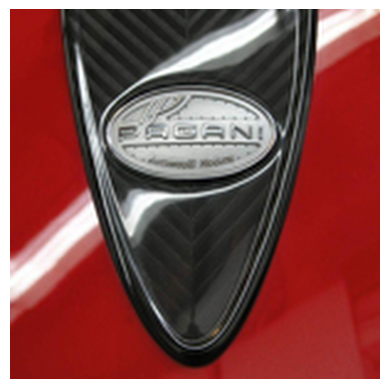

In [10]:
#selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[7]

plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

In [11]:
'''Now we need to rename the car brands to ensure consistency with the second dataset, this is necessary for merging'''

image_df['Label'] = image_df['Label'].str.replace('Original', '').str.replace('logo', '').str.replace(' ', '')
image_df

,Label,Filename,Image
0,Pagani,Image_29.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,Pagani,Image_28.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Pagani,Image_14.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,Pagani,Image_16.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,Pagani,Image_17.png,<PIL.Image.Image image mode=RGB size=150x150 a...
...,...,...,...
364,Audi,Image_27.png,<PIL.Image.Image image mode=RGB size=150x150 a...
365,Audi,Image_19.png,<PIL.Image.Image image mode=RGB size=150x150 a...
366,Audi,Image_30.png,<PIL.Image.Image image mode=RGB size=150x150 a...
367,Audi,Image_24.png,<PIL.Image.Image image mode=RGB size=150x150 a...


## Second (small) dataset

In [13]:
'''Read in the second data set'''

# image_directory = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\USA Car Logos"
image_directory = r"Data/USA Car Logos"

# list comprehension to get all image filenames
image_filenames = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

def process_images(image_directory, image_filenames):
    
    '''This function works similiar as the one above, just the folder structure is a bit different.
    Here all images are stored in the same folder, not split up in sub-folders by brand.'''
    
    image_data = []
    for filename in image_filenames:
        try:
            image_path = os.path.join(image_directory, filename)  
            img = Image.open(image_path)  
            img = img.convert('RGB') 
            img_resized = img.resize((150, 150), Image.LANCZOS)  
            image_data.append({'Filename': filename, 'Image': img_resized})
        except Exception as e:
            print(f"Error processing image {filename}: {e}")
    image_df = pd.DataFrame(image_data)
    return image_df

image2_df=process_images(image_directory, image_filenames)
image2_df

,Filename,Image
0,Ford.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,LotusCars.png,<PIL.Image.Image image mode=RGB size=150x150 a...
5,Audi.png,<PIL.Image.Image image mode=RGB size=150x150 a...
6,Mercedes-AMG.png,<PIL.Image.Image image mode=RGB size=150x150 a...
7,Ferrari.png,<PIL.Image.Image image mode=RGB size=150x150 a...
8,Maserati.png,<PIL.Image.Image image mode=RGB size=150x150 a...
9,Porsche.png,<PIL.Image.Image image mode=RGB size=150x150 a...


In [14]:
"""Run to get an overview of this dataset as well"""

#Get an overview of the number of images per label
labelinfo2 = image2_df['Filename'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo2))
print('The number of images per brand ranges from',labelinfo2.min(),'to', labelinfo2.max())
print('The average is',labelinfo2.mean().round(),'and the median is', labelinfo2.median())

#Get an overivew of image characteristics (size, channels) in the dataset
def get_image_characteristics(image):
    size = image.size
    mode = image.mode 
    return size, mode

image_sizes = []
image_modes = []
for index, row in image2_df.iterrows():
    size, mode = get_image_characteristics(row['Image']) 
    image_sizes.append(size)
    image_modes.append(mode)

image_characteristics_df2 = pd.DataFrame({'Size': image_sizes, 'Mode': image_modes})

#Print an overview of the image characteristics
print('\nAbout the Images in the Dataset:')
print('The number of different sizes is', len(image_characteristics_df2['Size'].unique()))
print('Image size(s) in the dataset:', image_characteristics_df2['Size'].unique())
print('The number of different color modes is', len(image_characteristics_df2['Mode'].unique()))
print('Color mode(s) in the dataset:', image_characteristics_df2['Mode'].unique())

#Get an overivew of the first rows of this df
print('\n')
print('Quick view of dataframe:')
image2_df.head()

About the Distribtion of Labels:
The number of different brands is 11
The number of images per brand ranges from 1 to 1
The average is 1.0 and the median is 1.0

About the Images in the Dataset:
The number of different sizes is 1
Image size(s) in the dataset: [(150, 150)]
The number of different color modes is 1
Color mode(s) in the dataset: ['RGB']


Quick view of dataframe:


,Filename,Image
0,Ford.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,LotusCars.png,<PIL.Image.Image image mode=RGB size=150x150 a...


In [15]:
#rename files here as well
image2_df['Label'] = image2_df['Filename'].apply(lambda x: x.split('.')[0])
image2_df

,Filename,Image,Label
0,Ford.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Ford
1,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...,AstonMartin
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Bentley
3,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...,FiskerAutomotive
4,LotusCars.png,<PIL.Image.Image image mode=RGB size=150x150 a...,LotusCars
5,Audi.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Audi
6,Mercedes-AMG.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Mercedes-AMG
7,Ferrari.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Ferrari
8,Maserati.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Maserati
9,Porsche.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Porsche


## Data Augmentation

In [16]:
'''Since we have little data available, we will augment the data using tensorflow augmentation mechanisms.
It seems to be more common to add these layers right into a CNN model, but since we want to use the same augmented data
for our other models as well, we will do it separately.'''

img_size=150

augment = tf.keras.Sequential([
    layers.Resizing(img_size, img_size), #resize again, to ensure every image is 150x150 for sure
    layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
    layers.RandomContrast(factor=0.2), #adjusting contrast
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomZoom(0.2), #zooming a bit
    layers.RandomBrightness([-0.3,0.3]), #adjusting colout brightness
    layers.RandomRotation(0.1), #randomly rotating
    layers.Rescaling(1./255) #rescaling in order to normalize
])

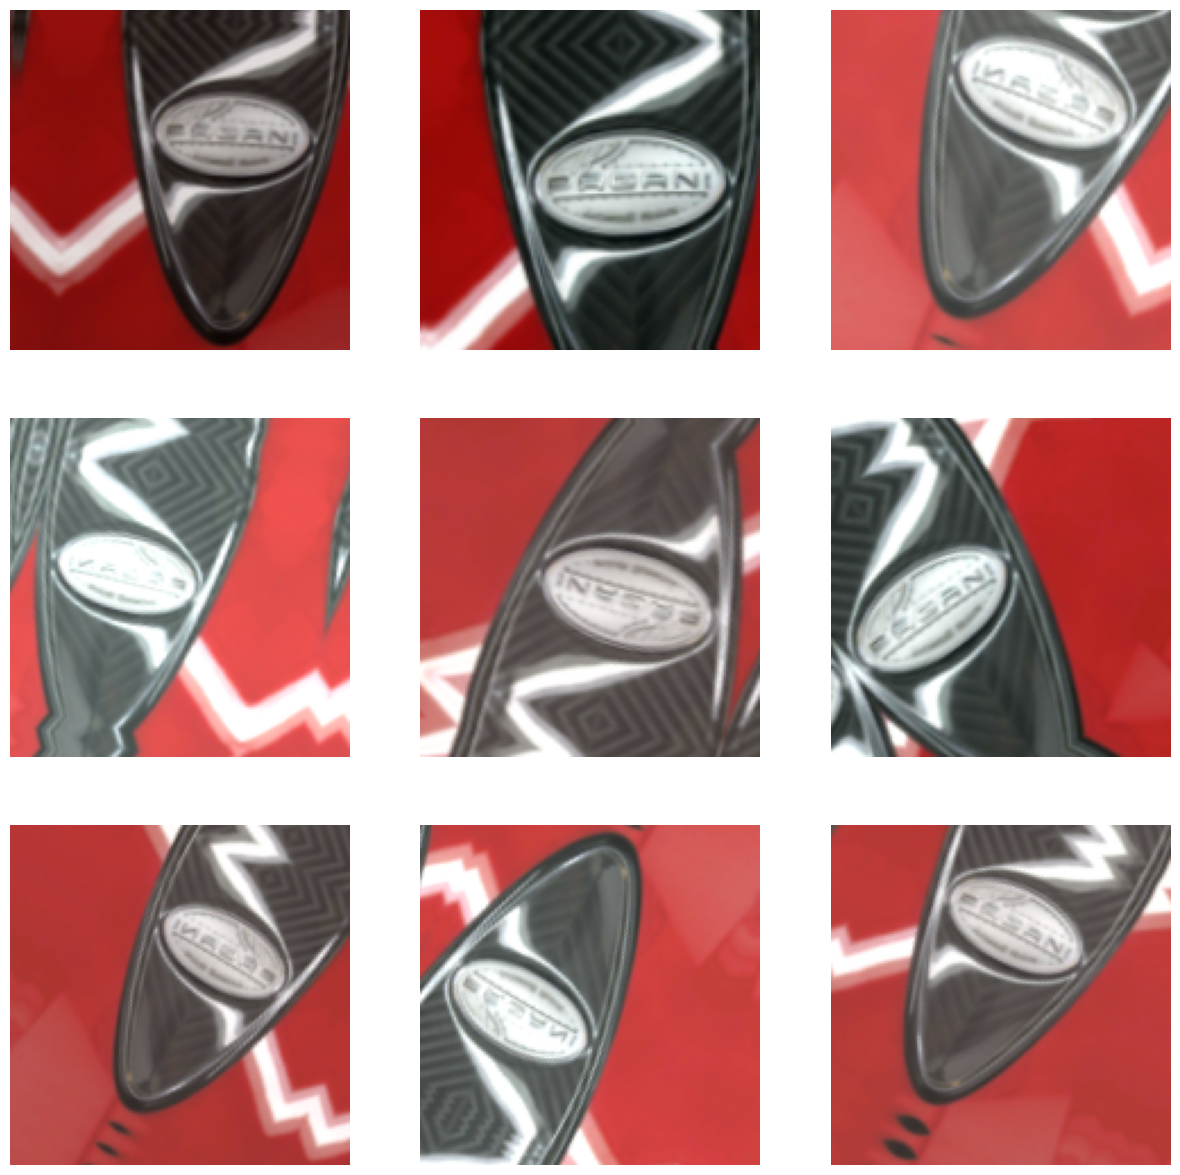

In [17]:
#plot one image
some_pic_tf = tf.cast(tf.expand_dims(some_pic, 0), tf.float32)

plt.figure(figsize=(15, 15))

for i in range(9):
    augmented_image = augment(some_pic_tf)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [18]:
#data augmentation

def augment_images(image, label, num_aug):
    
    '''This function applies a random sequence of augmentation to images in the DataFrame'''
    
    augmented_images = []
    
    #define the augmentation layers
    augmentation_layers = [
        layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
        layers.RandomContrast(factor=0.2), #adjusting contrast
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        layers.RandomZoom(0.2), #zooming a bit
        layers.RandomBrightness([-0.3,0.3]), #adjusting colour brightness
        layers.RandomRotation(0.1), #randomly rotating
        layers.Rescaling(1./255) #rescaling in order to normalize
    ]
    
    #shuffle the augmentation layers
    random.shuffle(augmentation_layers)
    
    for _ in range(num_aug):
        for aug_func in augmentation_layers:
            augmented_image = aug_func(image)
            augmented_images.append((augmented_image, label))
    
    return augmented_images

In [19]:
#apply augmentation to our data (dataset 1)

#list to store augmented images
images_tensors = []

#Apply augmentations to each image in the dataframe
for index, row in image_df.iterrows():
    image = row['Image']
    label = row['Label']
    augmented_images = augment_images(image, label, 5)
    images_tensors.extend(augmented_images)
augmented_df = pd.DataFrame(images_tensors, columns=['Augmented_Image', 'Label'])
augmented_df

,Augmented_Image,Label
0,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
1,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
2,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
3,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Pagani
4,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
...,...,...
12910,"(((tf.Tensor(194.65878, shape=(), dtype=float3...",Audi
12911,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Audi
12912,"(((tf.Tensor(189.63612, shape=(), dtype=float3...",Audi
12913,"(((tf.Tensor(200.0, shape=(), dtype=float32), ...",Audi


In [21]:
#apply augmentation to our data (dataset 2)

#list to store augmented images
images_tensors_2 = []

#Apply augmentations to each image in the dataframe
for index, row in image2_df.iterrows():
    image = row['Image']
    label = row['Label']
    augmented_images = augment_images(image, label, 10)
    images_tensors_2.extend(augmented_images)
augmented2_df = pd.DataFrame(images_tensors_2, columns=['Augmented_Image', 'Label'])
augmented2_df

,Augmented_Image,Label
0,"(((tf.Tensor(250.975, shape=(), dtype=float32)...",Ford
1,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Ford
2,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Ford
3,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Ford
4,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Ford
...,...,...
765,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
766,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
767,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
768,"(((tf.Tensor(250.30669, shape=(), dtype=float3...",Lamborghini


## Merge and Encode the two dataframes

In [25]:
#merge
augmented_df_full = pd.concat([augmented_df, augmented2_df], ignore_index=True)
augmented_df_full

,Augmented_Image,Label
0,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
1,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
2,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
3,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Pagani
4,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani
...,...,...
13680,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
13681,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
13682,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini
13683,"(((tf.Tensor(250.30669, shape=(), dtype=float3...",Lamborghini


In [26]:
#encode classes
label_encoder = LabelEncoder()
augmented_df_full['Label_coded'] = label_encoder.fit_transform(augmented_df_full['Label'])
augmented_df_full

,Augmented_Image,Label,Label_coded
0,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani,12
1,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani,12
2,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani,12
3,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Pagani,12
4,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Pagani,12
...,...,...,...
13680,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini,8
13681,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini,8
13682,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Lamborghini,8
13683,"(((tf.Tensor(250.30669, shape=(), dtype=float3...",Lamborghini,8


In [27]:
augmented_df_full['Augmented_Image'].dtype

dtype('O')

In [28]:
augmented_df_full['Label_coded'].unique()

array([12, 11, 10,  8,  5,  3,  6,  7,  2,  4,  0,  9, 13,  1])

In [29]:
#to check if labels match
augmented_df_full['Label'].unique()

array(['Pagani', 'Mercedes-AMG', 'Maserati', 'Lamborghini',
       'FiskerAutomotive', 'Bugatti', 'Ford', 'Koenigsegg', 'Bentley',
       'Ferrari', 'AstonMartin', 'LotusCars', 'Porsche', 'Audi'],
      dtype=object)

In [34]:
# Test function
augmented_df_full.to_csv('Data/augmented_df_full.csv', index=False)
# Reload 
test = pd.read_csv('Data/augmented_df_full.csv')

In [21]:
#save as csv, such that we don't have to perform augmentations again when reloading
#ISSUE: images not saved as tensors but as strings, so does it help at all? 

#Function to convert tensor to string
def tensor_to_string(tensor):
    return np.array2string(tensor.numpy())

#Function to convert string to tensor
def string_to_tensor(string):
    return tf.constant(eval(string))

augmented_df_copy=augmented_df_full.copy()
# Convert tensor data to strings
augmented_df_copy['Augmented_Image'] = augmented_df_copy['Augmented_Image'].apply(tensor_to_string)

augmented_df_copy.to_csv(r'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\augmented_df.csv',index=False)
#--> uncomment this for the first time, comment it out then and uncomment the lower lines:

#load it the next time
# file_path=r'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\augmented_df_full.csv'
# augmented_df_full=pd.read_csv(file_path)
#augmented_df_full['Augmented_Image'] = augmented_df_full['Augmented_Image'].apply(string_to_tensor)


In [36]:
'''This function will save all the augmented images in subfolders, each labelled with the respective brand.
This is needed for the pretarined-model.
Run only one time'''

def save_tensors_to_folders(df, image_directory):
    for index, row in df.iterrows():
        filename = row['Label']
        new_filename = f"{filename}_{index}.png" 
        # Check if the brand subfolder exists, if not, create it
        subfolder_path = os.path.join(image_directory, 'Augmented Images', filename)
        os.makedirs(subfolder_path, exist_ok=True)
        
        # Save the image to the corresponding subfolder
        image = row['Augmented_Image']
        image_pil = tf.keras.preprocessing.image.array_to_img(image)
        image_path = os.path.join(subfolder_path, new_filename)
        image_pil.save(image_path, format='PNG')
        
# image_directory = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project"
image_directory = r"Data"

save_tensors_to_folders(augmented_df_full, image_directory)

## Prepare for Modelling

In [37]:
#split it into features and labels
images = augmented_df_full[['Augmented_Image']]
labels = augmented_df_full[['Label_coded']]

In [38]:
X_train ,X_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

In [39]:
#Further split the training data into test and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [40]:
#convert to numpy array
X_train = np.array([np.array(img) for img in X_train.iloc[:, 0]])
X_test = np.array([np.array(img) for img in X_test.iloc[:, 0]])
X_val = np.array([np.array(img) for img in X_val.iloc[:, 0]])

#reshaping array to the desired shape
X_train = X_train.reshape(len(X_train), 150, 150, 3)
X_test = X_test.reshape(len(X_test), 150, 150, 3)
X_val = X_val.reshape(len(X_val), 150, 150, 3)

y_train=y_train.values
y_test=y_test.values
y_val = y_val.values

y_train=y_train.reshape(len(y_train),1)
y_test=y_test.reshape(len(y_test),1)
y_val=y_val.reshape(len(y_val),1)

In [41]:
#check shapes
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(8758, 150, 150, 3)
(2737, 150, 150, 3)
(2190, 150, 150, 3)
(8758, 1)
(2737, 1)
(2190, 1)


### some notes on the structure of a CNN:
- strides: smaller strides (1) helps to presere finer details in input image, retains more information from input image, and has higher spacial accuracy. A larger stride (2+) can downsample the spatial dimensions -> reducing computational complexity and memory usage, captures global features or large-scale patterns better and sometimes improves the robustness of model to variations in object scale+positions.
- verbosity level controls the amount of information printed during the training process, it depends on the mode set: verbosity=0, means silent mode - nothing is printed during training;: the default mode is 1, which means progress bars are displayed for each epoch; and 2 displays one line per epoch with the progress bar and the training metrics.
- K-fold cross-validation is a technique used to assess the performance and generalization ability of model. When applying the dataset is divided into k subsets (k-1 folds for training and the remaining fold for testing). This process is repeated k times, with each fold used once as the validation data, and the performance metrics are averaged across all iterations to obtain a more reliable estimation of the model's performance.

In [42]:
#CNN Model
cnn_model_1 = Sequential()

#convolutional layers with Batch Normalization and MaxPooling
cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=32, strides=(1,1), input_shape=(150, 150, 3), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1,1), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1,1), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1,1), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout layer
cnn_model_1.add(Dropout(0.2))

#Global average pooling layer
cnn_model_1.add(GlobalAveragePooling2D())

#Output layer
cnn_model_1.add(Dense(14, activation='softmax'))

#get an overview
cnn_model_1.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,046 (953.30 KB)

 Trainable params: 243,342 (950.55 KB)

 Non-trainable params: 704 (2.75 KB)

In [43]:
#Compile the model (without cross-validation)
cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the model 30 epochs
H_1_1 = cnn_model_1.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 249s 897ms/step - accuracy: 0.4290 - loss: 1.8377 - val_accuracy: 0.5804 - val_loss: 1.2784
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 261s 950ms/step - accuracy: 0.7358 - loss: 0.8806 - val_accuracy: 0.7922 - val_loss: 0.8321
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8353 - loss: 0.5517 - val_accuracy: 0.7886 - val_loss: 0.6804
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.8488 - loss: 0.4769 - val_accuracy: 0.7667 - val_loss: 0.7123
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8601 - loss: 0.4346 - val_accuracy: 0.8146 - val_loss: 0.5507
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8678 - loss: 0.4016 - val_accuracy: 0.8292 - val_loss: 0.5180
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 258s 940ms/step - accuracy: 0.8667 - loss: 0.4143 - val_accuracy: 0.8457 - val_loss: 0.4574
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 225s 822ms/step - accuracy: 0.8622 - loss: 0.413

In [44]:
#(without cross-validation)
print("Evaluate on test data")
test_loss, test_acc = cnn_model_1.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

Evaluate on test data
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.9453 - loss: 0.1647

Test accuracy: 0.9455608129501343


Why k=5?:

"To summarize, there is a bias-variance trade-off associated with the choice of k in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance."
- Page 184, An Introduction to Statistical Learning, 2013

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R (1st ed.). Corr. 7th printing 2017. Springer Texts in Statistics.

In [91]:
#compile the model with k-fold
##IMO THIS IS NOT NECESSARY; ACCURACY+LOSS IS THE SAME WITHOUT K-FOLD CROSS

cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

#Define K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

#Initialize lists to store performance metrics
acc_per_fold = []
loss_per_fold = []

#K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(inputs, targets):
    print(f'Fold {fold_no}...')

    #Fit data to model
    H = cnn_model_1.fit(inputs[train_index], targets[train_index], epochs=30, verbose=2)

    #Generate generalization metrics
    scores = cnn_model_1.evaluate(inputs[test_index], targets[test_index], verbose=0)
    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    
    #Append scores to lists
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #Increase fold number
    fold_no += 1

#Performnace Metrics
print('Average scores across all folds:')
print(f'Accuracy: {np.mean(acc_per_fold)} (+/- {np.std(acc_per_fold)})')
print(f'Loss: {np.mean(loss_per_fold)} (+/- {np.std(loss_per_fold)})')

Fold 1...
Epoch 1/30
289/289 - 178s - 617ms/step - accuracy: 0.5728 - loss: 1.3689
Epoch 2/30
289/289 - 165s - 570ms/step - accuracy: 0.7905 - loss: 0.6855
Epoch 3/30
289/289 - 166s - 575ms/step - accuracy: 0.8410 - loss: 0.5169
Epoch 4/30
289/289 - 171s - 593ms/step - accuracy: 0.8495 - loss: 0.4757
Epoch 5/30
289/289 - 171s - 593ms/step - accuracy: 0.8632 - loss: 0.4122
Epoch 6/30
289/289 - 169s - 586ms/step - accuracy: 0.8674 - loss: 0.4084
Epoch 7/30
289/289 - 168s - 580ms/step - accuracy: 0.8673 - loss: 0.4131
Epoch 8/30
289/289 - 171s - 591ms/step - accuracy: 0.8754 - loss: 0.3931
Epoch 9/30
289/289 - 172s - 594ms/step - accuracy: 0.8729 - loss: 0.3931
Epoch 10/30
289/289 - 171s - 591ms/step - accuracy: 0.8690 - loss: 0.4095
Epoch 11/30
289/289 - 171s - 591ms/step - accuracy: 0.8824 - loss: 0.3566
Epoch 12/30
289/289 - 171s - 592ms/step - accuracy: 0.8940 - loss: 0.3295
Epoch 13/30
289/289 - 172s - 596ms/step - accuracy: 0.8975 - loss: 0.3291
Epoch 14/30
289/289 - 172s - 595ms/st

Epoch 19/30
289/289 - 172s - 594ms/step - accuracy: 0.9987 - loss: 0.0050
Epoch 20/30
289/289 - 173s - 598ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 21/30
289/289 - 173s - 600ms/step - accuracy: 0.9999 - loss: 0.0015
Epoch 22/30
289/289 - 171s - 593ms/step - accuracy: 0.9995 - loss: 0.0032
Epoch 23/30
289/289 - 169s - 584ms/step - accuracy: 0.9996 - loss: 0.0026
Epoch 24/30
289/289 - 168s - 583ms/step - accuracy: 0.9992 - loss: 0.0041
Epoch 25/30
289/289 - 169s - 586ms/step - accuracy: 0.9950 - loss: 0.0174
Epoch 26/30
289/289 - 169s - 584ms/step - accuracy: 0.9976 - loss: 0.0082
Epoch 27/30
289/289 - 172s - 594ms/step - accuracy: 0.9996 - loss: 0.0028
Epoch 28/30
289/289 - 172s - 597ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 29/30
289/289 - 172s - 595ms/step - accuracy: 0.9989 - loss: 0.0211
Epoch 30/30
289/289 - 172s - 596ms/step - accuracy: 0.9921 - loss: 0.0302
Score for fold 4: Loss of 0.4168641269207001; Accuracy of 94.83730792999268%
Fold 5...
Epoch 1/30
289/289 - 175s

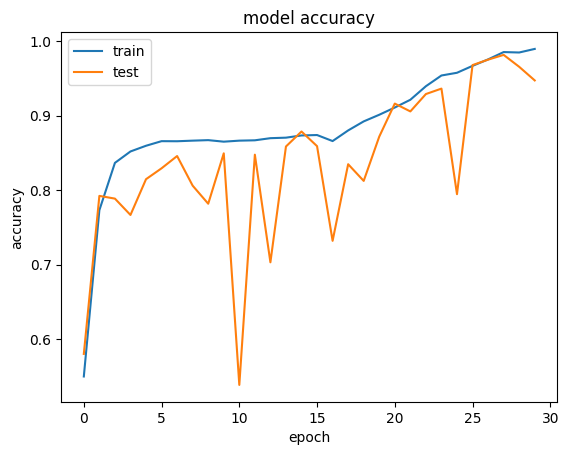

In [45]:
#summarize history for accuracy
plt.plot(H_1_1.history['accuracy'])
plt.plot(H_1_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

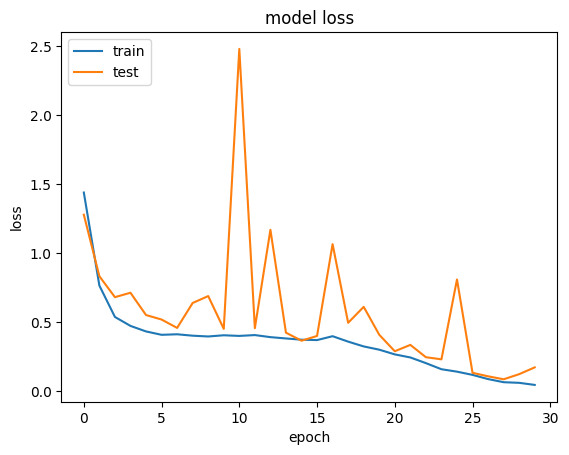

In [46]:
plt.plot(H_1_1.history['loss'])
plt.plot(H_1_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
#predict on test set
predictions = cnn_model_1.predict(X_test)

#create target names
targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

#convert probability predictions to table using class names for column names
prediction_df = pd.DataFrame(predictions, columns=targetnames)
print(prediction_df.head())

#convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step
    AstonMartin          Audi       Bentley       Bugatti       Ferrari  \
0  1.349820e-08  1.319752e-06  3.845121e-07  4.339435e-07  7.499470e-06   
1  4.096609e-01  1.590155e-03  3.801957e-02  7.604391e-02  1.387615e-03   
2  8.011710e-04  5.322217e-07  3.614632e-05  2.966540e-05  2.215898e-07   
3  1.259099e-14  6.354475e-15  5.091240e-15  8.148439e-18  7.197569e-15   
4  1.000000e+00  1.248763e-13  6.651804e-11  1.576855e-12  1.808047e-14   

   FiskerAutomotive          Ford    Koenigsegg   Lamborghini     LotusCars  \
0      9.998505e-01  8.377990e-05  7.818176e-07  4.556435e-06  2.581335e-05   
1      1.344749e-03  1.405879e-01  1.341096e-01  8.495027e-03  8.248430e-04   
2      6.067654e-04  6.076123e-04  4.640784e-05  2.088140e-08  2.486684e-06   
3      3.648861e-14  1.307569e-11  4.487259e-18  1.907631e-16  1.621724e-15   
4      1.195393e-14  3.354211e-11  6.017740e-12  1.842867e-11  5.910129e-13   

       Maserati  Mercedes-AMG   

In [48]:
f1 = f1_score(y_test, predicted_labels, average='micro')
print(f'F1 Score: {f1}')

F1 Score: 0.9455608330288637


<Axes: xlabel='Predicted Label', ylabel='True Label'>

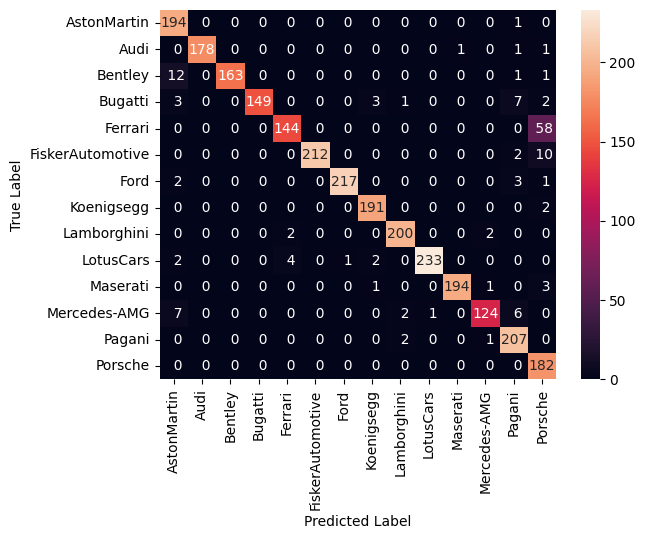

In [49]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

confusion_df = pd.DataFrame(conf_matrix, index=targetnames, columns=targetnames)

#Set the names of the x and y axis --> for readability of the heatmap
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt='3g')

## 2nd CNN (AlexNet like)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#CNN Model 2 - AlexNet structure
cnn_model_2 = Sequential()

# Layer 1: Convolutional layer with 96 filters, each 11x11 in size, and ReLU activation
cnn_model_2.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(150, 150, 3)))

# Layer 2: MaxPooling layer with 3x3 pool size and stride 2x2
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3: Convolutional layer with 256 filters, each 5x5 in size, and ReLU activation
cnn_model_2.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))

# Layer 4: MaxPooling layer with 3x3 pool size and stride 2x2
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 5: Convolutional layer with 384 filters, each 3x3 in size, and ReLU activation
cnn_model_2.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 6: Convolutional layer with 384 filters, each 3x3 in size, and ReLU activation
cnn_model_2.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 7: Convolutional layer with 256 filters, each 3x3 in size, and ReLU activation
cnn_model_2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 8: MaxPooling layer with 3x3 pool size and stride 2x2
cnn_model_2.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten layer to convert 3D features to 1D feature vector
cnn_model_2.add(Flatten())

# Layer 9: Fully connected (Dense) layer with 4096 units and ReLU activation
cnn_model_2.add(Dense(4096, activation='relu'))

# Layer 10: Dropout layer with a dropout rate of 0.5
cnn_model_2.add(Dropout(0.5))

# Layer 11: Fully connected (Dense) layer with 4096 units and ReLU activation
cnn_model_2.add(Dense(4096, activation='relu'))

# Layer 12: Dropout layer with a dropout rate of 0.5
cnn_model_2.add(Dropout(0.5))

# Layer 13: Output layer with softmax activation for classification
cnn_model_2.add(Dense(10, activation='softmax'))

# Print model summary
cnn_model_2.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,010,762 (114.48 MB)

 Trainable params: 30,010,762 (114.48 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Compile the model
cnn_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store performance metrics
acc_per_fold_2 = []
loss_per_fold_2 = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X_train, y_train):
    print(f'Fold {fold_no}...')
    
    #fit data to the model
    H_2 = cnn_model_2.fit(X_train[train_index], y_train[train_index], epochs=20, validation_data=(X_train[test_index], y_train[test_index]))


    # Generate generalization metrics
    scores = cnn_model_2.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    
    acc_per_fold_2.append(scores[1] * 100)
    loss_per_fold_2.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# Print average performance metrics
print('Average scores across all folds:')
print(f'Accuracy: {np.mean(acc_per_fold_2)} (+/- {np.std(acc_per_fold_2)})')
print(f'Loss: {np.mean(loss_per_fold_2)} (+/- {np.std(loss_per_fold_2)})')

Fold 1...


In [ ]:
# summarize history for accuracy
plt.plot(H_2.history['accuracy'])
plt.plot(H_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H_2.history['loss'])
plt.plot(H_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#predict on test set
predictions_2 = cnn_model_2.predict(X_test)

#create target names
targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

#convert probability predictions to table using class names for column names
prediction_df_2 = pd.DataFrame(predictions_2, columns=targetnames)
print(prediction_df_2.head())

#convert predictions to class labels
predicted_labels_2 = np.argmax(predictions_2, axis=1)
print(predicted_labels_2)

In [ ]:
#confusion matrix
conf_matrix_2 = confusion_matrix(y_test, predicted_labels)

confusion_df_2 = pd.DataFrame(conf_matrix_2, index=targetnames, columns=targetnames)
confusion_df_2.index.name = 'True Label'
confusion_df_2.columns.name = 'Predicted Label'

sns.heatmap(confusion_df_2, annot=True, fmt='3g')

## SVM

In [53]:
#split it into features and labels for SVM
images = augmented_df_full.Augmented_Image#['Augmented_Image']
labels = augmented_df_full.Label_coded

In [54]:
X_train ,X_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

In [55]:
#convert tensor data to np arrays
X_train_numpy = np.array([image.numpy() for image in X_train])
X_test_numpy = np.array([image.numpy() for image in X_test])

#flatten images
X_train_flattened = X_train_numpy.reshape(len(X_train_numpy), -1)
X_test_flattened = X_test_numpy.reshape(len(X_test_numpy), -1)

#PCA by reducing it to 2 dimensions
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.fit_transform(X_test_flattened)

In [56]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(10976, 2)
(2744, 2)


In [57]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [60]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'coef0': [0, 0.5, 1, 2]  # Coef0 for 'poly' and 'sigmoid' kernels
}

# Create the SVM model
model = SVC(kernel='rbf', degree=2)

# Perform grid search
model_svm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
model_svm.fit(X_train_pca, y_train)

# Get the best parameters and the corresponding accuracy
best_params = model_svm.best_params_
best_accuracy = model_svm.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Best parameters: {'C': 100, 'coef0': 0, 'gamma': 0.001}
Best accuracy: 0.3874824800527777


In [61]:
print_score(model_svm, X_train_pca, y_train, X_test_pca, y_test, train=True)
print_score(model_svm, X_train_pca, y_train, X_test_pca, y_test, train=False)

Train Result:
Accuracy Score: 95.17%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.976540    0.919497    0.915607    0.925153    0.963064   
recall       0.930168    0.966931    0.965854    0.970399    0.934927   
f1-score     0.952790    0.942618    0.940059    0.947236    0.948787   
support    716.000000  756.000000  820.000000  777.000000  753.000000   

                    5           6           7           8           9  \
precision    0.961055    0.954333    0.964722    0.928404    0.977907   
recall       0.963476    0.933562    0.940476    0.955314    0.976771   
f1-score     0.962264    0.943833    0.952445    0.941667    0.977339   
support    794.000000  873.000000  756.000000  828.000000  861.000000   

                   10          11          12          13  accuracy  \
precision    0.938903    0.992908    0.978093    0.949233  0.951713   
recall       0.944

## Pre-trained MobileNet

In [163]:
'''Tis will load the data with tf -- the png versions and from the already augmented images'''
folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\Augmented Images"

train = image_dataset_from_directory(folder_path,
    seed=42,
    validation_split=0.2,
    subset='training',
    image_size=(224,224), #the model expects 224x224
)

Found 13720 files belonging to 14 classes.
Using 10976 files for training.


In [164]:
val =image_dataset_from_directory(folder_path, 
    seed=42,
    validation_split=0.2,
    subset='validation',
    image_size=(224,224),
)
# Printing class names
class_names = train.class_names
print("Class names:", class_names)

Found 13720 files belonging to 14 classes.
Using 2744 files for validation.
Class names: ['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari', 'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini', 'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']


### Preparation

In [136]:
#Rescale pixel values
#model expects pixel values in [-1, 1] (right now they are [0, 255])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [172]:
#Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               input_tensor=None,
                                               include_top=False,
                                               weights='imagenet')

In [156]:
#This feature extractor converts each image into a 7x7x1280 block of features
#example batch of images:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


Feature extraction

Next, the convolutional base created from the previous step will be frozen and used as a feature extractor. Additionally, a classifier will be added on top of it and the top-level classifier trained.

Freeze the convolutional base It is important to freeze the convolutional base before compiling and training the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [173]:
#we want the model weights to be updated during training
base_model.trainable = True

In [158]:
#look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [159]:
#Add lassification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [160]:
#Dense layer to convert features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(14, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 14)


In [161]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [175]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [177]:
#compile the model
base_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

H_3 = model.fit(train,
                    epochs=30,
                    validation_data=val)  

Epoch 1/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 1019s 3s/step - accuracy: 0.0498 - loss: 0.5954 - val_accuracy: 0.0583 - val_loss: 19.3579
Epoch 2/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 918s 3s/step - accuracy: 0.0477 - loss: 0.1138 - val_accuracy: 0.0598 - val_loss: 20.4306
Epoch 3/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 918s 3s/step - accuracy: 0.0492 - loss: 0.1274 - val_accuracy: 0.0605 - val_loss: 15.6274
Epoch 4/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 920s 3s/step - accuracy: 0.0580 - loss: 0.0960 - val_accuracy: 0.0466 - val_loss: 8.3634
Epoch 5/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 957s 3s/step - accuracy: 0.0478 - loss: 0.0854 - val_accuracy: 0.0375 - val_loss: 15.4569
Epoch 6/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 1041s 3s/step - accuracy: 0.0487 - loss: 0.0648 - val_accuracy: 0.0302 - val_loss: 25.9135
Epoch 7/30
201/343 ━━━━━━━━━━━━━━━━━━━━ 6:07 3s/step - accuracy: 0.0437 - loss: 0.0734

KeyboardInterrupt: 

In [ ]:
#get results
acc_3 = H_3.history['accuracy']
val_acc_3 = H_3.history['val_accuracy']
loss_3 = H_3.history['loss']
val_loss_3 = H_3.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc_3, label='Training Accuracy')
plt.plot(val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

In [ ]:
#loss
plt.subplot(2, 1, 2)
plt.plot(loss_3, label='Training Loss')
plt.plot(val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()